# 09 - Hydrological impacts of climate change

## Performing bias correction on climate model data to perform climate change impact studies on hydrology

This notebook will allow evaluating the impacts of climate change on the hydrology of a catchment. We will use the data we previously generated in notebook "08 - Getting and bias-correcting CMIP6 data", where we produced both reference and future forcing datasets.

You can apply this notebook to other models, climate datasets, and generally pick and choose parts of various notebooks to build your own complete workflow.

In [1]:
"""
Import the required packages
"""
import datetime as dt
import warnings

import xarray as xr
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

## Simulate the flows on the reference period

In this step, we will take the reference period climate data and run the GR4JCN hydrological model with it. We will then plot a graph to see the streamflow representative of the reference period.

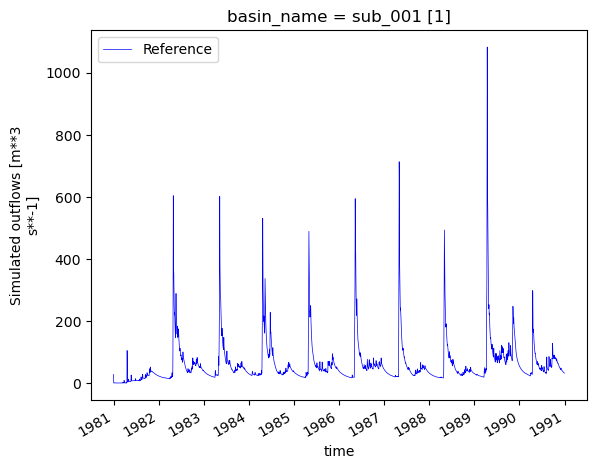

In [2]:
from ravenpy import Emulator
from ravenpy.new_config import commands as rc

# We will run a GR4JCN model here, so let's import the emulator
from ravenpy.new_config.emulators import GR4JCN

# Define the hydrological response unit. We can use the information from the tutorial notebook #02! Here we are using
# arbitrary data for a test catchment.
hru = {}
hru = dict(
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    hru_type="land",
)

# Define the start and end dates of the reference period:
start_date = dt.datetime(1981, 1, 1)
end_date = dt.datetime(1990, 12, 31)

# Alternate names for the data in the climate data NetCDF files
alt_names = {
    "TEMP_MIN": "tasmin",
    "TEMP_MAX": "tasmax",
    "PRECIP": "pr",
}

# Types of data required by the Raven GR4JCN instance
data_type = ["TEMP_MAX", "TEMP_MIN", "PRECIP"]
data_kwds = {
    "ALL": {
        "elevation": hru["elevation"],
        "latitude": hru["latitude"],
        "longitude": hru["longitude"],
    }
}
# Start a model instance, in this case a GR4JCN model emulator.
m = GR4JCN(
    params=[0.529, -3.396, 407.29, 1.072, 16.9, 0.947],
    Gauge=[
        rc.Gauge.from_nc(
            # name of the reference period dataset.
            "reference_dataset.nc",
            data_type=data_type,
            alt_names=alt_names,
            data_kwds=data_kwds,
        )
    ],
    HRUs=[hru],
    StartDate=start_date,
    EndDate=end_date,
    RunName="test",
    CustomOutput=rc.CustomOutput("YEARLY", "AVERAGE", "PRECIP", "ENTIRE_WATERSHED"),
    GlobalParameter={"AVG_ANNUAL_RUNOFF": 208.480},
)

# Prepare the emulator by writing files on disk
e = Emulator(config=m)

# Run the model and get the outputs.
outputs_reference = e.run()

outputs_reference.hydrograph.q_sim.plot(label="Reference", color="blue", lw=0.5)
plt.legend()

## Now do the same but for the future period!
We will copy the block of code from above, changing only the file path (from reference dataset to future dataset) as well as the start and end dates.

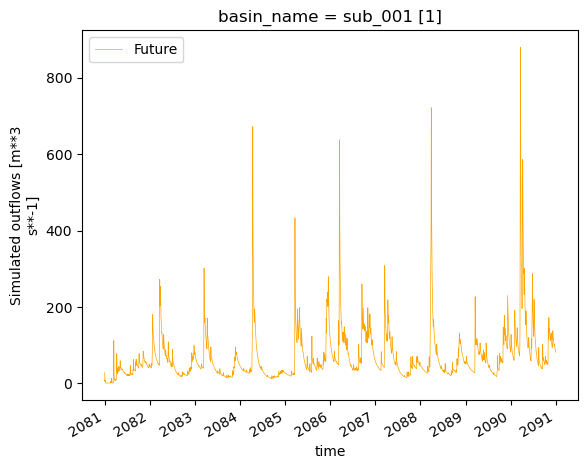

In [3]:
# Define the start and end dates of the reference period:
start_date = dt.datetime(2081, 1, 1)
end_date = dt.datetime(2090, 12, 31)

# Start a new model instance, again in this case a GR4JCN model emulator.
m = GR4JCN(
    params=[0.529, -3.396, 407.29, 1.072, 16.9, 0.947],
    Gauge=[
        rc.Gauge.from_nc(
            # name of the future period dataset.
            "future_dataset.nc",
            data_type=data_type,
            alt_names=alt_names,
            data_kwds=data_kwds,
        )
    ],
    HRUs=[hru],
    StartDate=start_date,
    EndDate=end_date,
    RunName="test",
    CustomOutput=rc.CustomOutput("YEARLY", "AVERAGE", "PRECIP", "ENTIRE_WATERSHED"),
    GlobalParameter={"AVG_ANNUAL_RUNOFF": 208.480},
)

# Prepare the emulator by writing files on disk
e = Emulator(config=m)

# Run the model and get the outputs.
outputs_future = e.run()

outputs_future.hydrograph.q_sim.plot(label="Future", color="orange", lw=0.5)
plt.legend()

## You have just generated streamflows for the reference and future periods!
We can analyze these hydrographs with many tools in PAVICS-Hydro, or export them to use elsewhere, or use them as inputs to another process!

In [4]:
# Get the path to the hydrograph file:
outputs_future.files["hydrograph"]

PosixPath('/tmp/tmp_4ltn8s_/output/test_Hydrographs.nc')

In [5]:
# Work with the hydrograph data directly:
outputs_future.hydrograph

<xarray.Dataset>
Dimensions:     (time: 3652, nbasins: 1)
Coordinates:
  * time        (time) datetime64[ns] 2081-01-01 2081-01-02 ... 2090-12-31
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Data variables:
    precip      (time) float64 ...
    q_sim       (time, nbasins) float64 ...
    q_obs       (time, nbasins) float64 ...
    q_in        (time, nbasins) float64 ...
Attributes:
    Conventions:  CF-1.6
    featureType:  timeSeries
    history:      Created by Raven
    description:  Standard Output